<a href="https://colab.research.google.com/github/Ishank2301/Comprehensive-ML-Handbook/blob/main/Bird_Audio_Classification_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kenjee_z_by_hp_unlocked_challenge_3_signal_processing_path = kagglehub.dataset_download('kenjee/z-by-hp-unlocked-challenge-3-signal-processing')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from itertools import groupby
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
CAPUCHIN_FILE = os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Capuchinbird_Clips','XC114131-0.wav')
NOT_CAPUCHIN_FILE= os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Not_Capuchinbird_Clips','Crickets-chirping-9.wav')

In [ ]:
CAPUCHIN_FILE

'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC114131-0.wav'

In [ ]:
def load_wav_16k_mono(filename):
    file_contents=tf.io.read_file(filename)
    wav,sample_rate=tf.audio.decode_wav(file_contents,desired_channels=1)
    wav=tf.squeeze(wav,axis=-1)
    sample_rate=tf.cast(sample_rate,dtype=tf.int64)
    wav=tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
    return wav

In [ ]:
wave=load_wav_16k_mono(CAPUCHIN_FILE)
nwave=load_wav_16k_mono(NOT_CAPUCHIN_FILE)

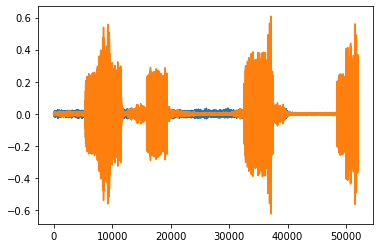

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [ ]:
POSITIVE=os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Capuchinbird_Clips')
NEGATIVE=os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Not_Capuchinbird_Clips')

In [ ]:
pos=tf.data.Dataset.list_files(POSITIVE+'/*.wav')
neg=tf.data.Dataset.list_files(NEGATIVE+'/*.wav')

In [ ]:
pos.as_numpy_iterator().next()

b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC227469-3.wav'

In [ ]:
positives=tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives=tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data=positives.concatenate(negatives)

In [ ]:
lengths=[]
for file in os.listdir(os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Capuchinbird_Clips')):
    tensor_wave=load_wav_16k_mono(os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Parsed_Capuchinbird_Clips',file))
    lengths.append(len(tensor_wave))

In [ ]:
def preprocess(file_path,label):
    wav=load_wav_16k_mono(file_path)
    wav=wav[:48000]
    zero_padding=tf.zeros([48000]-tf.shape(wav),dtype=tf.float32)
    wav=tf.concat([zero_padding,wav],0)
    spectrogram=tf.signal.stft(wav,frame_length=320,frame_step=32)
    spectrogram=tf.abs(spectrogram)
    spectrogram=tf.expand_dims(spectrogram,axis=2)
    return spectrogram,label

In [ ]:
filepath,label=positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectrogram,label=preprocess(filepath,label)

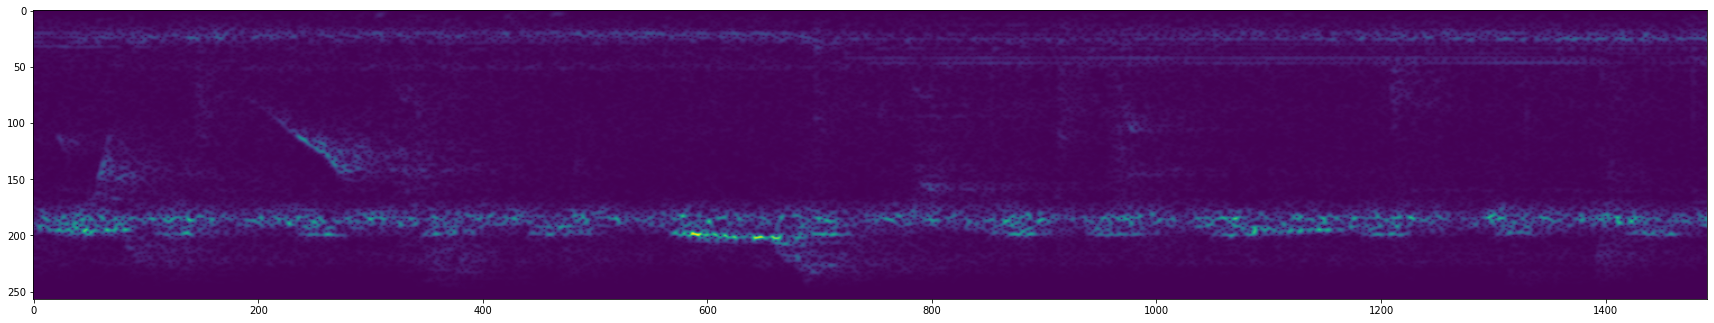

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
data.as_numpy_iterator().next()

(b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC600460-4.wav',
 1.0)

In [ ]:
data=data.map(preprocess)
data=data.cache()
data=data.shuffle(buffer_size=1000)
data=data.batch(16)
data=data.prefetch(8)

In [ ]:
train=data.take(36)
test=data.skip(36).take(15)

In [ ]:
samples,labels=train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [ ]:
model=Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(1491,257,1)))
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.compile('Adam',loss='BinaryCrossentropy',metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1489, 255, 16)     160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1487, 253, 16)     2320      
_________________________________________________________________
flatten (Flatten)            (None, 6019376)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               770480256 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist=model.fit(train,epochs=5,validation_data=test)

Epoch 1/5
36/36 [==============================] - 27s 341ms/step - loss: 3.3245 - accuracy: 0.6215 - recall: 0.8961 - precision: 0.8679 - val_loss: 0.2384 - val_accuracy: 0.5171 - val_recall: 1.0000 - val_precision: 0.9863
Epoch 2/5
36/36 [==============================] - 12s 326ms/step - loss: 0.2965 - accuracy: 0.4479 - recall: 0.9789 - precision: 0.9789 - val_loss: 0.0017 - val_accuracy: 0.4701 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/5
36/36 [==============================] - 12s 328ms/step - loss: 0.1638 - accuracy: 0.5191 - recall: 0.9533 - precision: 0.9728 - val_loss: 0.0750 - val_accuracy: 0.4615 - val_recall: 1.0000 - val_precision: 0.9655
Epoch 4/5
36/36 [==============================] - 12s 334ms/step - loss: 0.0731 - accuracy: 0.5503 - recall: 0.9875 - precision: 0.9693 - val_loss: 0.0563 - val_accuracy: 0.5342 - val_recall: 1.0000 - val_precision: 0.9672
Epoch 5/5
36/36 [==============================] - 12s 337ms/step - loss: 0.0276 - accuracy: 0.6111 - re

In [ ]:
# Prediction for a single batch
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)

# converting logits to classes
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

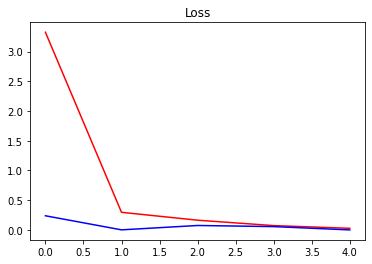

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'],'r')
plt.plot(hist.history['val_loss'],'b')
plt.show()

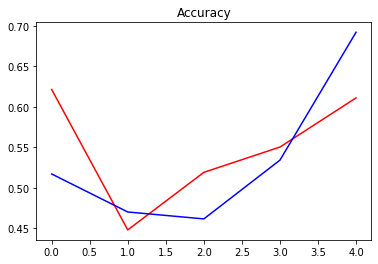

In [ ]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'],'r')
plt.plot(hist.history['val_accuracy'],'b')
plt.show()

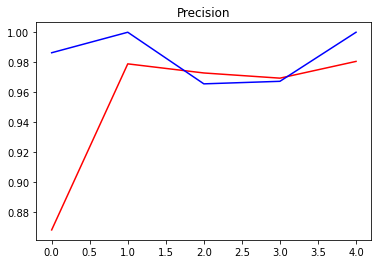

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'],'r')
plt.plot(hist.history['val_precision'],'b')
plt.show()

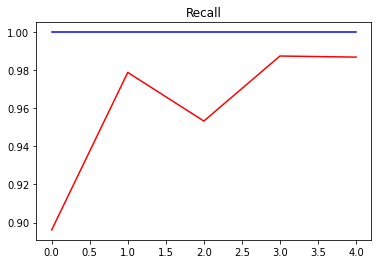

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'],'r')
plt.plot(hist.history['val_recall'],'b')
plt.show()

In [ ]:
X_test,y_test=test.as_numpy_iterator().next()

In [ ]:
y_hat=model.predict(X_test)

In [ ]:
y_hat=[1 if prediction>0.5 else 0 for prediction in y_hat]

In [ ]:
def load_mp3_16k_mono(filename):
    res=tfio.audio.AudioIOTensor(filename)
    tensor=res.to_tensor()
    tensor=tf.math.reduce_sum(tensor,axis=1)/2
    sample_rate=res.rate
    sample_rate=tf.cast(sample_rate,dtype=tf.int64)
    wav=tfio.audio.resample(tensor,rate_in=sample_rate,rate_out=16000)
    return wav

In [ ]:
mp3=os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Forest Recordings', 'recording_02.mp3')
wav=load_mp3_16k_mono(mp3)
audio_slices=tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)
samples,index=audio_slices.as_numpy_iterator().next()

In [ ]:
def preprocess_mp3(sample,index):
    sample=sample[0]
    zero_padding=tf.zeros([48000]-tf.shape(sample),dtype=tf.float32)
    wav=tf.concat([zero_padding,sample],0)
    spectrogram=tf.signal.stft(wav,frame_length=320,frame_step=32)
    spectrogram=tf.abs(spectrogram)
    spectrogram=tf.expand_dims(spectrogram,axis=2)
    return spectrogram

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

In [ ]:
y_hat=[key for key,group in groupby(y_hat)]
calls=tf.math.reduce_sum(y_hat).numpy()

In [ ]:
results={}
for file in os.listdir(os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Forest Recordings')):
    FILEPATH=os.path.join('/kaggle/input','z-by-hp-unlocked-challenge-3-signal-processing','Forest Recordings',file)
    wav=load_mp3_16k_mono(FILEPATH)
    audio_slices=tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)
    audio_slices=audio_slices.map(preprocess_mp3)
    audio_slices=audio_slices.batch(64)
    y_hat=model.predict(audio_slices)
    results[file]=y_hat

In [ ]:
class_preds={}
for file,logits in results.items():
    class_preds[file]=[1 if prediction>0.99 else 0 for prediction in logits]


In [ ]:
postprocessed={}
for file,scores in class_preds.items():
    postprocessed[file]=tf.math.reduce_sum([key for key,group in groupby(scores)]).numpy()
postprocessed

{'recording_76.mp3': 0,
 'recording_62.mp3': 0,
 'recording_48.mp3': 11,
 'recording_44.mp3': 1,
 'recording_45.mp3': 3,
 'recording_06.mp3': 13,
 'recording_43.mp3': 5,
 'recording_68.mp3': 1,
 'recording_95.mp3': 3,
 'recording_17.mp3': 3,
 'recording_65.mp3': 4,
 'recording_74.mp3': 0,
 'recording_10.mp3': 5,
 'recording_49.mp3': 0,
 'recording_15.mp3': 2,
 'recording_37.mp3': 4,
 'recording_64.mp3': 3,
 'recording_39.mp3': 2,
 'recording_04.mp3': 11,
 'recording_28.mp3': 6,
 'recording_05.mp3': 0,
 'recording_80.mp3': 1,
 'recording_57.mp3': 3,
 'recording_12.mp3': 0,
 'recording_59.mp3': 6,
 'recording_67.mp3': 0,
 'recording_09.mp3': 0,
 'recording_79.mp3': 0,
 'recording_14.mp3': 0,
 'recording_63.mp3': 5,
 'recording_86.mp3': 4,
 'recording_47.mp3': 5,
 'recording_03.mp3': 0,
 'recording_33.mp3': 0,
 'recording_08.mp3': 23,
 'recording_51.mp3': 3,
 'recording_35.mp3': 0,
 'recording_81.mp3': 5,
 'recording_30.mp3': 1,
 'recording_88.mp3': 0,
 'recording_75.mp3': 1,
 'recording_

In [ ]:
import csv
with open('submission.csv','w',newline='')as f:
    writer=csv.writer(f,delimiter=',')
    writer.writerow(['clip_name','call_count'])
    for key, value in postprocessed.items():
        writer.writerow([key,value])